# Predicting NBA Salaries with Machine Learning

<img src="https://www.overtimebasket.com/wp-content/uploads/2021/01/IMG_2370-1.jpg" width="500"/>

## Importing packages

In [ ]:
from BRScraper import nba

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

from xgboost import XGBRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install BRScraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 111.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.1 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
models = ['SVM','Random Forest','Elastic Net','AdaBoost','Gradient Boosting','LGBM', 'Linear Regression', 'XGBoost', 'Decision Tree', 'CatBoost', 'Extra Trees']

# Path to data
path_data = r'/content/drive/My Drive/DS 340W/NBA Salaries'

sep = r'/'

# Season to predict salaries
desired_seasons = ['2023-24','2022-23','2021-22']

In [ ]:
data_cap = {'Year': [2024],
            'Cap Maximum': [142.00]}
cap = pd.DataFrame(data_cap)

cap1 = pd.read_html('https://www.spotrac.com/nba/cba/')[0]
cap1 = cap1[['Year','Cap Maximum']]
cap1['Cap Maximum'] = (cap1['Cap Maximum'].str.replace('$','').str.replace(',','')).astype(float)/1000000

cap = pd.concat([cap, cap1], ignore_index=True)
cap = cap.astype({'Year': 'int32'})

cap.head()

,Year,Cap Maximum
0,2024,142.00
1,2023,136.02
2,2022,123.66
3,2021,112.41
4,2020,109.14


## Opening and processing the data

In [ ]:
def get_data_salary(desired_seasons):

    # Players current salaries info
    salary = nba.get_current_salaries()

    salary = salary.drop_duplicates('Player').reset_index(drop=True)

    # Normalizing names
    salary['Player'] = salary['Player'].str.replace('.','')
    salary['Player'] = salary['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    # Salaries from previous seasons
    for desired_season in desired_seasons:
        url = 'https://hoopshype.com/salaries/players/'+str(int(desired_season[:4])-1)+'-20'+str(int(desired_season[5:7])-1)

        last_season = pd.read_html(url)[0]
        last_season = last_season.drop(['Unnamed: 0',str(int(desired_season[:4])-1)+'/'+str(int(desired_season[5:7])-1)+'(*)'],
                                        axis=1)
        last_season = last_season.rename(columns={str(int(desired_season[:4])-1)+'/'+str(int(desired_season[5:7])-1):
                                                 str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1)})

        salary1 = salary[salary['Player'].isin(last_season['Player'])==False]

        last_season['Player'] = last_season['Player'].str.replace('.','')
        last_season['Player'] = last_season['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

        last_season = last_season.drop_duplicates('Player', keep='first').reset_index(drop=True)

        salary = last_season.merge(salary, on='Player', how='left', validate='1:1')

        salary = pd.concat([salary, salary1], ignore_index=True)

        salary = salary.drop_duplicates('Player', keep='first').reset_index(drop=True)

    salary = salary.drop(columns={'Tm'})

    for col in salary.columns:
        if col not in ['Player']:
            salary[col] = (salary[col].str.replace('$','').str.replace(',','')).astype(float)

            salary[col] = salary[col].fillna(-1000000)
            salary[col] = salary[col]/1000000

    return salary

In [ ]:
salary = get_data_salary(desired_seasons)

salary.to_csv(path_data+sep+'salaries.csv',sep=',',decimal='.',index=False)

salary.head()

,Player,2020-21,2021-22,2022-23,2023-24,2024-25,2025-26,2026-27,2027-28,2028-29,Guaranteed
0,Stephen Curry,43.01,45.78,48.07,51.92,55.76,59.61,-1.00,-1.00,-1.00,167.28
1,Chris Paul,41.36,30.80,28.40,30.80,30.00,-1.00,-1.00,-1.00,-1.00,15.80
2,Russell Westbrook,41.36,44.21,47.08,3.84,4.03,-1.00,-1.00,-1.00,-1.00,7.86
3,James Harden,41.25,44.31,33.00,35.64,-1.00,-1.00,-1.00,-1.00,-1.00,35.64
4,John Wall,41.25,44.31,47.35,6.80,-1.00,-1.00,-1.00,-1.00,-1.00,6.80


In [ ]:
def get_individual_stats(desired_seasons):

    df_stats = pd.DataFrame()

    for desired_season in desired_seasons:
        # Stats for S-1
        per_game = nba.get_stats(int(desired_season[:4]), info='per_game', rename=True)
        totals = nba.get_stats(int(desired_season[:4]), info='totals', rename=True)
        avancados = nba.get_stats(int(desired_season[:4]), info='advanced', rename=True)

        # Droping repeated variables
        totals = totals.drop(['Pos','Age','G','GS','Season'], axis=1).reset_index(drop=True)
        avancados = avancados.drop(['Pos','Age','G','MP_advanced','Season'], axis=1).reset_index(drop=True)

        cols = ['Player','Season','Pos','Age','Tm','G','GS']

        # Defining variables type
        for coluna in per_game.columns:
            if coluna not in cols:
                per_game[coluna] = per_game[coluna].astype(float)
        for coluna in totals.columns:
            if coluna not in cols:
                totals[coluna] = totals[coluna].astype(float)
        for coluna in avancados.columns:
            if coluna not in cols:
                avancados[coluna] = avancados[coluna].astype(float)

        times = per_game.drop_duplicates(subset=['Player'],keep='last').reset_index(drop=True)
        times = times['Tm']

        per_game = per_game.drop_duplicates(subset=['Player'],keep='first').reset_index(drop=True)
        totals = totals.drop_duplicates(subset=['Player'],keep='first').reset_index(drop=True)
        avancados = avancados.drop_duplicates(subset=['Player'],keep='first').reset_index(drop=True)

        per_game['Tm'] = times
        totals['Tm'] = times
        avancados['Tm'] = times

        # Merging the bases
        stats = per_game.merge(avancados, on=['Player','Tm'], how='left', validate='1:1')
        stats = stats.merge(totals, on=['Player','Tm'], how='left', validate='1:1').fillna(0)

        stats = stats.astype({'G':int,'GS':int,'Age':int})

        # Normalizing names
        stats['Player'] = stats['Player'].str.replace('.','')
        stats['Player'] = stats['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
        # Trying to match Jrs
        stats['Player'] = stats['Player'].apply(lambda x: x.replace(' Jr', '') if x.endswith(' Jr') and x not in ['Jaren Jackson Jr', 'Tim Hardaway Jr', 'Gary Trent Jr', 'Larry Nance Jr',
                                                                                                                 'Duane Washington Jr', 'Scottie Pippen Jr', 'Vince Williams Jr', 'Ron Harper Jr'] else x)
        df_stats = pd.concat([df_stats, stats], ignore_index=True)

    df_stats = df_stats.rename(columns={'Season':'Season S-1'})

    return df_stats

In [ ]:
stats = get_individual_stats(desired_seasons)

stats.to_csv(path_data+sep+'stats.csv',sep=',',decimal='.',index=False)

stats

,Player,Pos,Age,Tm,G,GS,MP_per_game,FG_per_game,FGA_per_game,FG%_per_game,3P_per_game,3PA_per_game,3P%_per_game,2P_per_game,2PA_per_game,2P%_per_game,eFG%_per_game,FT_per_game,FTA_per_game,FT%_per_game,ORB_per_game,DRB_per_game,TRB_per_game,AST_per_game,STL_per_game,BLK_per_game,TOV_per_game,PF_per_game,PTS_per_game,Season S-1,PER_advanced,TS%_advanced,3PAr_advanced,FTr_advanced,ORB%_advanced,DRB%_advanced,TRB%_advanced,AST%_advanced,STL%_advanced,BLK%_advanced,TOV%_advanced,USG%_advanced,OWS_advanced,DWS_advanced,WS_advanced,WS/48_advanced,OBPM_advanced,DBPM_advanced,BPM_advanced,VORP_advanced,MP_totals,FG_totals,FGA_totals,FG%_totals,3P_totals,3PA_totals,3P%_totals,2P_totals,2PA_totals,2P%_totals,eFG%_totals,FT_totals,FTA_totals,FT%_totals,ORB_totals,DRB_totals,TRB_totals,AST_totals,STL_totals,BLK_totals,TOV_totals,PF_totals,PTS_totals
0,Precious Achiuwa,C,23,TOR,55,12,20.70,3.60,7.30,0.48,0.50,2.00,0.27,3.00,5.40,0.56,0.52,1.60,2.30,0.70,1.80,4.10,6.00,0.90,0.60,0.50,1.10,1.90,9.20,2022-23,15.20,0.55,0.27,0.31,9.30,24.40,16.30,6.30,1.30,2.60,11.40,19.40,0.80,1.40,2.20,0.09,-1.40,-0.80,-2.30,-0.10,1140.00,196.00,404.00,0.48,29.00,108.00,0.27,167.00,296.00,0.56,0.52,87.00,124.00,0.70,100.00,228.00,328.00,50.00,31.00,30.00,59.00,102.00,508.00
1,Steven Adams,C,29,MEM,42,42,27.00,3.70,6.30,0.60,0.00,0.00,0.00,3.70,6.20,0.60,0.60,1.10,3.10,0.36,5.10,6.50,11.50,2.30,0.90,1.10,1.90,2.30,8.60,2022-23,17.50,0.56,0.00,0.49,20.10,25.30,22.70,11.20,1.50,3.70,19.80,14.60,1.30,2.10,3.40,0.14,-0.30,0.90,0.60,0.70,1133.00,157.00,263.00,0.60,0.00,1.00,0.00,157.00,262.00,0.60,0.60,47.00,129.00,0.36,214.00,271.00,485.00,97.00,36.00,46.00,79.00,98.00,361.00
2,Bam Adebayo,C,25,MIA,75,75,34.60,8.00,14.90,0.54,0.00,0.20,0.08,8.00,14.70,0.55,0.54,4.30,5.40,0.81,2.50,6.70,9.20,3.20,1.20,0.80,2.50,2.80,20.40,2022-23,20.10,0.59,0.01,0.36,8.00,23.60,15.50,15.90,1.70,2.40,12.70,25.20,3.60,3.80,7.40,0.14,0.80,0.80,1.50,2.30,2598.00,602.00,1114.00,0.54,1.00,12.00,0.08,601.00,1102.00,0.55,0.54,324.00,402.00,0.81,184.00,504.00,688.00,240.00,88.00,61.00,187.00,208.00,1529.00
3,Ochai Agbaji,SG,22,UTA,59,22,20.50,2.80,6.50,0.43,1.40,3.90,0.35,1.40,2.70,0.53,0.53,0.90,1.20,0.81,0.70,1.30,2.10,1.10,0.30,0.30,0.70,1.70,7.90,2022-23,9.50,0.56,0.59,0.18,3.90,6.90,5.40,7.50,0.60,1.00,9.00,15.80,0.90,0.40,1.30,0.05,-1.70,-1.40,-3.00,-0.30,1209.00,165.00,386.00,0.43,81.00,228.00,0.35,84.00,158.00,0.53,0.53,56.00,69.00,0.81,43.00,78.00,121.00,67.00,16.00,15.00,41.00,99.00,467.00
4,Santi Aldama,PF,22,MEM,77,20,21.80,3.20,6.80,0.47,1.20,3.50,0.35,2.00,3.40,0.59,0.56,1.40,1.90,0.75,1.10,3.70,4.80,1.30,0.60,0.60,0.80,1.90,9.00,2022-23,13.90,0.59,0.51,0.27,5.40,18.00,11.70,7.60,1.30,2.60,9.30,16.00,2.10,2.40,4.60,0.13,-0.30,0.80,0.50,1.10,1682.00,247.00,525.00,0.47,94.00,266.00,0.35,153.00,259.00,0.59,0.56,108.00,144.00,0.75,85.00,286.00,371.00,97.00,45.00,48.00,60.00,143.00,696.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,Delon Wright,PG,28,SAC,63,39,27.70,3.80,8.20,0.46,1.00,2.70,0.37,2.80,5.50,0.51,0.53,1.60,2.00,0.80,1.00,3.20,4.30,4.40,1.60,0.50,1.30,1.20,10.20,2020-21,16.30,0.56,0.33,0.24,4.10,13.10,8.60,23.00,2.80,1.50,12.60,16.30,2.50,1.80,4.30,0.12,0.60,1.50,2.20,1.80,1748.00,240.00,518.00,0.46,64.00,172.00,0.37,176.00,346.00,0.51,0.53,101.00,126.00,0.80,65.00,204.00,269.00,278.00,101.00,30.00,83.00,75.00,645.00
1680,Thaddeus Young,PF,32,CHI,68,23,24.30,5.40,9.70,0.56,0.20,0.70,0.27,5.30,9.10,0.58,0.57,1.00,1.70,0.63,2.50,3.80,6.20,4.30,1.10,0.60,2.00,2.20,12.10,2020-21,20.30,0.58,0.07,0.17,11.40,16.90,14.20,27.10,2.20,2.10,16.10,22.30,2.80,2.20,5.10,0.15,1.90,1.40,3.30,2.20,1652.00,370.00,662.00,0.56,12.00,45.00,0.27,358.00,617.00,0.58,0.57,71.00,113.00,0.63,168.00,255.00,423.00,291.00,74.00,40.00,137.00,152.0

In [ ]:
def select_data(desired_seasons, stats, salary, cap):

    df_f = pd.DataFrame()

    for desired_season in desired_seasons:
        # Selecting only salaries of S and S-1
        salary1 = salary[['Player', desired_season,
                         str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1)]]

        stats1 = stats[stats['Season S-1']==str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1)]

        df = stats1.merge(salary1, on='Player', how='left', validate='1:1')

        df = df.rename(columns={str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1):'Salary S-1',
                                  desired_season:'Salary S'})

        # Removing null values
        df = df[(df['Salary S']!=-1) & (df['Salary S'].notna())]

        df['Year S'] = ('20'+((df['Season S-1'].str[5:7]).astype(int)+1).astype(str)).astype(int)
        df['Year S-1'] = ('20'+(df['Season S-1'].str[5:7]).astype(str)).astype(int)

        cap2 = cap.rename(columns={'Cap Maximum':'Cap Maximum S', 'Year':'Year S'})
        df = df.merge(cap2, how='left', on='Year S', validate='m:1')

        cap2 = cap2.rename(columns={'Cap Maximum S':'Cap Maximum S-1', 'Year S':'Year S-1'})
        df = df.merge(cap2, how='left', on='Year S-1', validate='m:1')

        df['% of Cap S-1'] = df['Salary S-1']/df['Cap Maximum S-1']*100
        df['% of Cap S-1'][df['% of Cap S-1']<0] = -1

        df['% of Cap S'] = df['Salary S']/df['Cap Maximum S']*100
        df['% of Cap S'][df['% of Cap S']<0] = -1

        # Get dummies for positions
        pos = pd.get_dummies(df['Pos']).astype(int)
        for col in pos.columns:
            if len(col)>3:
                pos = pos.rename(columns={col: col.split('-')[0]})
        pos = pos[['PG','SG','SF','PF','C']]
        pos = pos.groupby(pos.columns, axis=1).sum()

        df = df.join(pos)
        df = df.drop(columns={'Pos','Year S','Year S-1'}).reset_index(drop=True)

        df_f = pd.concat([df_f, df], ignore_index=True)

    df_f = df_f.fillna(0)

    return df_f

In [ ]:
df = select_data(desired_seasons, stats, salary, cap)

df.to_csv(path_data+sep+'final_data.csv',sep=',',decimal='.',index=False)

df

,Player,Age,Tm,G,GS,MP_per_game,FG_per_game,FGA_per_game,FG%_per_game,3P_per_game,3PA_per_game,3P%_per_game,2P_per_game,2PA_per_game,2P%_per_game,eFG%_per_game,FT_per_game,FTA_per_game,FT%_per_game,ORB_per_game,DRB_per_game,TRB_per_game,AST_per_game,STL_per_game,BLK_per_game,TOV_per_game,PF_per_game,PTS_per_game,Season S-1,PER_advanced,TS%_advanced,3PAr_advanced,FTr_advanced,ORB%_advanced,DRB%_advanced,TRB%_advanced,AST%_advanced,STL%_advanced,BLK%_advanced,TOV%_advanced,USG%_advanced,OWS_advanced,DWS_advanced,WS_advanced,WS/48_advanced,OBPM_advanced,DBPM_advanced,BPM_advanced,VORP_advanced,MP_totals,FG_totals,FGA_totals,FG%_totals,3P_totals,3PA_totals,3P%_totals,2P_totals,2PA_totals,2P%_totals,eFG%_totals,FT_totals,FTA_totals,FT%_totals,ORB_totals,DRB_totals,TRB_totals,AST_totals,STL_totals,BLK_totals,TOV_totals,PF_totals,PTS_totals,Salary S,Salary S-1,Cap Maximum S,Cap Maximum S-1,% of Cap S-1,% of Cap S,C,PF,PG,SF,SG
0,Precious Achiuwa,23,TOR,55,12,20.70,3.60,7.30,0.48,0.50,2.00,0.27,3.00,5.40,0.56,0.52,1.60,2.30,0.70,1.80,4.10,6.00,0.90,0.60,0.50,1.10,1.90,9.20,2022-23,15.20,0.55,0.27,0.31,9.30,24.40,16.30,6.30,1.30,2.60,11.40,19.40,0.80,1.40,2.20,0.09,-1.40,-0.80,-2.30,-0.10,1140.00,196.00,404.00,0.48,29.00,108.00,0.27,167.00,296.00,0.56,0.52,87.00,124.00,0.70,100.00,228.00,328.00,50.00,31.00,30.00,59.00,102.00,508.00,4.38,2.84,142.00,136.02,2.09,3.08,1,0,0,0,0
1,Steven Adams,29,MEM,42,42,27.00,3.70,6.30,0.60,0.00,0.00,0.00,3.70,6.20,0.60,0.60,1.10,3.10,0.36,5.10,6.50,11.50,2.30,0.90,1.10,1.90,2.30,8.60,2022-23,17.50,0.56,0.00,0.49,20.10,25.30,22.70,11.20,1.50,3.70,19.80,14.60,1.30,2.10,3.40,0.14,-0.30,0.90,0.60,0.70,1133.00,157.00,263.00,0.60,0.00,1.00,0.00,157.00,262.00,0.60,0.60,47.00,129.00,0.36,214.00,271.00,485.00,97.00,36.00,46.00,79.00,98.00,361.00,12.60,17.93,142.00,136.02,13.18,8.87,1,0,0,0,0
2,Bam Adebayo,25,MIA,75,75,34.60,8.00,14.90,0.54,0.00,0.20,0.08,8.00,14.70,0.55,0.54,4.30,5.40,0.81,2.50,6.70,9.20,3.20,1.20,0.80,2.50,2.80,20.40,2022-23,20.10,0.59,0.01,0.36,8.00,23.60,15.50,15.90,1.70,2.40,12.70,25.20,3.60,3.80,7.40,0.14,0.80,0.80,1.50,2.30,2598.00,602.00,1114.00,0.54,1.00,12.00,0.08,601.00,1102.00,0.55,0.54,324.00,402.00,0.81,184.00,504.00,688.00,240.00,88.00,61.00,187.00,208.00,1529.00,32.60,30.35,142.00,136.02,22.31,22.96,1,0,0,0,0
3,Ochai Agbaji,22,UTA,59,22,20.50,2.80,6.50,0.43,1.40,3.90,0.35,1.40,2.70,0.53,0.53,0.90,1.20,0.81,0.70,1.30,2.10,1.10,0.30,0.30,0.70,1.70,7.90,2022-23,9.50,0.56,0.59,0.18,3.90,6.90,5.40,7.50,0.60,1.00,9.00,15.80,0.90,0.40,1.30,0.05,-1.70,-1.40,-3.00,-0.30,1209.00,165.00,386.00,0.43,81.00,228.00,0.35,84.00,158.00,0.53,0.53,56.00,69.00,0.81,43.00,78.00,121.00,67.00,16.00,15.00,41.00,99.00,467.00,4.11,3.92,142.00,136.02,2.88,2.90,0,0,0,0,1
4,Santi Aldama,22,MEM,77,20,21.80,3.20,6.80,0.47,1.20,3.50,0.35,2.00,3.40,0.59,0.56,1.40,1.90,0.75,1.10,3.70,4.80,1.30,0.60,0.60,0.80,1.90,9.00,2022-23,13.90,0.59,0.51,0.27,5.40,18.00,11.70,7.60,1.30,2.60,9.30,16.00,2.10,2.40,4.60,0.13,-0.30,0.80,0.50,1.10,1682.00,247.00,525.00,0.47,94.00,266.00,0.35,153.00,259.00,0.59,0.56,108.00,144.00,0.75,85.00,286.00,371.00,97.00,45.00,48.00,60.00,143.00,696.00,2.19,-1.00,142.00,136.02,-1.00,1.55,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,Delon Wright,28,SAC,63,39,27.70,3.80,8.20,0.46,1.00,2.70,0.37,2.80,5.50,0.51,0.53,1.60,2.00,0.80,1.00,3.20,4.30,4.40,1.60,0.50,1.30,1.20,10.20,2020-21,16.30,0.56,0.33,0.24,4.10,13.10,8.60,23.00,2.80,1.50,12.60,16.30,2.50,1.80,4.30,0.12,0.60,1.50,2.20,1.80,1748.00,240.00,518.00,0.46,64.00,172.00,0.37,176.00,346.00,0.51,0.53,101.00,126.00,0.80,65.00,204.00,269.00,278.00,101.00,30.00,83.00,75.00,645.00,8.53,9.00,123.66,112.41,8.01,6.90,0,0,1,0,0
1275,Thaddeus Young,32,C

In [ ]:
def get_FAs(desired_seasons):

    # Get free agents
    FAs = pd.DataFrame()

    for desired_season in desired_seasons:
        FAs1 = pd.read_html('https://web.archive.org/web/20230816170811/https://www.spotrac.com/nba/free-agents/'+desired_season[:4])[0]
        FAs1 = FAs1.iloc[:,0]
        FAs2 = pd.read_html('https://web.archive.org/web/20230816170811/https://www.spotrac.com/nba/free-agents/')[1]
        FAs2 = FAs2.iloc[:,0]

        FA = pd.concat([FAs1,FAs2],ignore_index=True)
        FA = FA.to_frame(name="Player")

        FA['Season S-1'] = str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1)

        FAs = pd.concat([FA, FAs], ignore_index=True)

    FAs['Player'] = FAs['Player'].str.replace('.','')
    FAs['Player'] = FAs['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    return FAs

In [ ]:
FAs = get_FAs(desired_seasons)
FAs

,Player,Season S-1
0,Sep,2020-21
1,NaN,2020-21
2,2021,2020-21
3,Jerami Grant,2020-21
4,Fred VanVleet,2020-21
...,...,...
364,Jared Butler,2022-23
365,Trevor Keels,2022-23
366,Udoka Azubuike,2022-23
367,Jamal Cain,2022-23


In [ ]:
res = df.merge(FAs, on=['Player', 'Season S-1'], how='inner')
res

,Player,Age,Tm,G,GS,MP_per_game,FG_per_game,FGA_per_game,FG%_per_game,3P_per_game,3PA_per_game,3P%_per_game,2P_per_game,2PA_per_game,2P%_per_game,eFG%_per_game,FT_per_game,FTA_per_game,FT%_per_game,ORB_per_game,DRB_per_game,TRB_per_game,AST_per_game,STL_per_game,BLK_per_game,TOV_per_game,PF_per_game,PTS_per_game,Season S-1,PER_advanced,TS%_advanced,3PAr_advanced,FTr_advanced,ORB%_advanced,DRB%_advanced,TRB%_advanced,AST%_advanced,STL%_advanced,BLK%_advanced,TOV%_advanced,USG%_advanced,OWS_advanced,DWS_advanced,WS_advanced,WS/48_advanced,OBPM_advanced,DBPM_advanced,BPM_advanced,VORP_advanced,MP_totals,FG_totals,FGA_totals,FG%_totals,3P_totals,3PA_totals,3P%_totals,2P_totals,2PA_totals,2P%_totals,eFG%_totals,FT_totals,FTA_totals,FT%_totals,ORB_totals,DRB_totals,TRB_totals,AST_totals,STL_totals,BLK_totals,TOV_totals,PF_totals,PTS_totals,Salary S,Salary S-1,Cap Maximum S,Cap Maximum S-1,% of Cap S-1,% of Cap S,C,PF,PG,SF,SG
0,Nickeil Alexander-Walker,24,MIN,59,3,15.00,2.20,5.00,0.44,1.00,2.70,0.38,1.20,2.30,0.52,0.55,0.70,1.00,0.67,0.30,1.50,1.70,1.80,0.50,0.40,0.90,1.50,6.20,2022-23,11.60,0.56,0.54,0.20,1.90,10.50,6.30,16.70,1.70,2.00,14.60,17.90,0.30,0.80,1.10,0.06,-1.40,0.40,-0.90,0.20,884.00,131.00,295.00,0.44,61.00,159.00,0.38,70.00,136.00,0.52,0.55,40.00,60.00,0.67,15.00,86.00,101.00,108.00,32.00,21.00,55.00,88.00,363.00,4.69,5.01,142.00,136.02,3.68,3.30,0,0,0,0,1
1,Thanasis Antetokounmpo,30,MIL,37,0,5.60,0.50,1.20,0.43,0.00,0.20,0.00,0.50,1.00,0.53,0.43,0.30,0.60,0.50,0.40,0.80,1.20,0.40,0.10,0.10,0.30,0.60,1.40,2022-23,6.70,0.46,0.17,0.48,7.90,14.10,11.10,9.30,0.70,1.20,17.70,13.80,-0.10,0.20,0.10,0.02,-6.50,-1.10,-7.60,-0.30,206.00,20.00,46.00,0.43,0.00,8.00,0.00,20.00,38.00,0.53,0.43,11.00,22.00,0.50,15.00,29.00,44.00,15.00,3.00,3.00,12.00,22.00,51.00,2.02,1.88,142.00,136.02,1.38,1.42,0,1,0,0,0
2,Dalano Banton,23,TOR,31,2,9.00,1.80,4.20,0.42,0.50,1.60,0.29,1.30,2.50,0.51,0.48,0.50,0.80,0.71,0.40,1.10,1.50,1.20,0.40,0.40,0.60,1.10,4.60,2022-23,14.90,0.51,0.39,0.18,4.20,14.90,9.10,19.30,2.30,4.50,11.40,24.20,0.00,0.40,0.40,0.06,-1.10,0.60,-0.50,0.10,279.00,55.00,130.00,0.42,15.00,51.00,0.29,40.00,79.00,0.51,0.48,17.00,24.00,0.71,11.00,34.00,45.00,36.00,13.00,13.00,18.00,34.00,142.00,2.02,1.56,142.00,136.02,1.15,1.42,0,0,1,0,0
3,Keita Bates-Diop,27,SAS,67,42,21.70,3.50,6.90,0.51,0.80,2.10,0.39,2.70,4.80,0.56,0.57,1.80,2.20,0.79,1.00,2.70,3.70,1.50,0.70,0.30,0.80,0.90,9.70,2022-23,14.90,0.61,0.30,0.32,4.70,14.30,9.30,9.80,1.50,1.10,9.50,16.70,2.10,0.60,2.70,0.09,0.30,-0.90,-0.60,0.50,1452.00,236.00,465.00,0.51,56.00,142.00,0.39,180.00,323.00,0.56,0.57,119.00,150.00,0.79,65.00,183.00,248.00,103.00,46.00,20.00,56.00,63.00,647.00,2.35,1.88,142.00,136.02,1.38,1.65,0,1,0,0,0
4,Malik Beasley,26,LAL,81,27,25.80,4.60,11.60,0.40,2.90,8.10,0.36,1.70,3.40,0.48,0.52,0.60,0.80,0.77,0.40,3.10,3.50,1.50,0.80,0.10,1.10,1.30,12.70,2022-23,10.90,0.53,0.70,0.07,1.80,12.50,7.30,8.40,1.50,0.40,8.50,21.10,-0.20,1.60,1.40,0.03,-0.90,-1.00,-2.00,0.00,2093.00,370.00,937.00,0.40,235.00,658.00,0.36,135.00,279.00,0.48,0.52,50.00,65.00,0.77,35.00,248.00,283.00,124.00,65.00,9.00,90.00,107.00,1025.00,2.02,15.56,142.00,136.02,11.44,1.42,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Russell Westbrook,32,WAS,65,65,36.40,8.40,19.00,0.44,1.30,4.20,0.32,7.00,14.80,0.47,0.47,4.20,6.40,0.66,1.70,9.90,11.50,11.70,1.40,0.40,4.80,2.90,22.20,2020-21,19.50,0.51,0.22,0.33,4.90,28.60,16.80,48.60,1.70,0.80,18.00,30.20,0.50,3.20,3.70,0.07,2.60,1.10,3.70,3.40,2369.00,544.00,1238.00,0.44,86.00,273.00,0.32,458.00,965.00,0.47,0.47,271.00,413.00,0.66,109.00,641.00,750.00,763.00,89.00,23.00,312.00,190.00,1445.00,44.21,41.36,123.66,112.41,36.79,35.75,0,0,1,0,0
242,Coby White,20,CH

In [ ]:
res.value_counts('Season S-1')

Season S-1
2021-22    87
2022-23    84
2020-21    75
dtype: int64

## Exploratory Data Analysis

In [ ]:
sns.set(style='dark')
sns.set_theme(rc={'figure.dpi': 200}, font_scale=0.6)

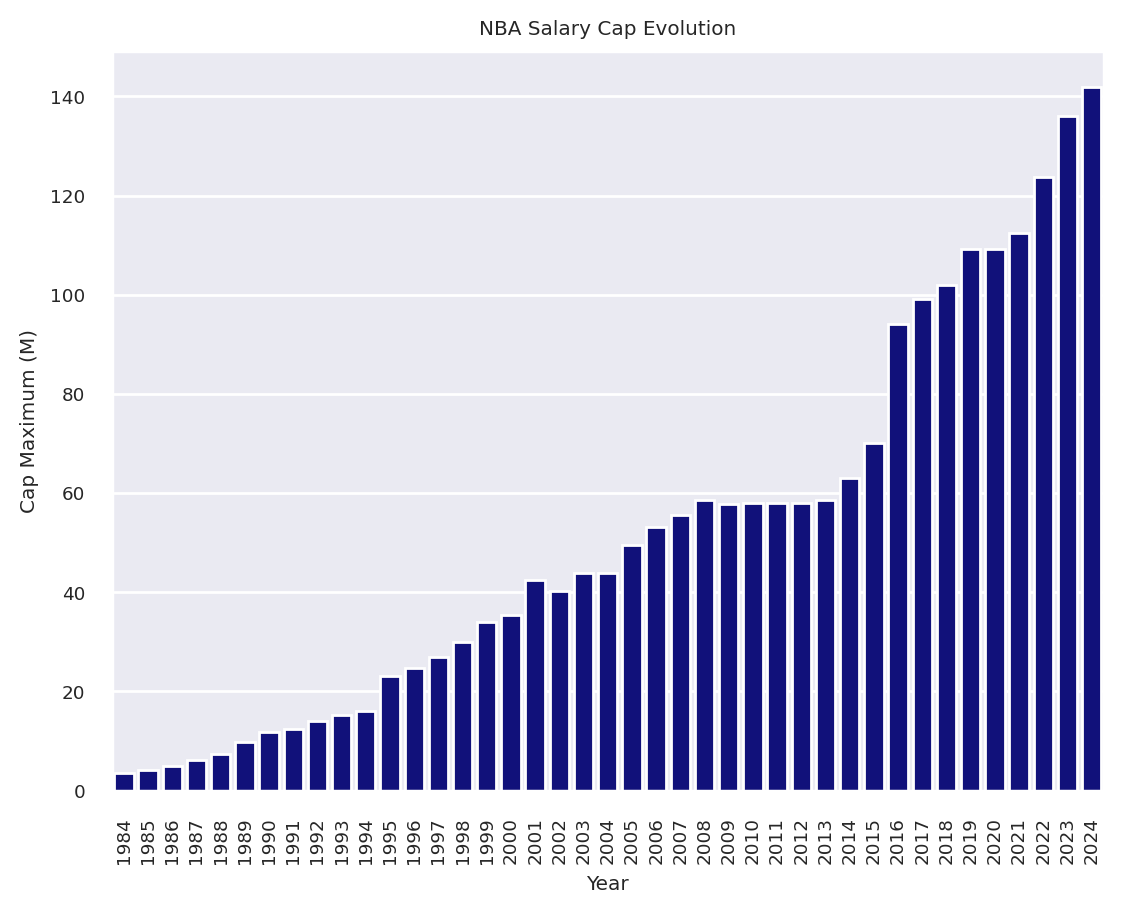

In [ ]:
plt.xticks(rotation=90)
evol = sns.barplot(data=cap,x='Year',y='Cap Maximum',color='darkblue').set(title='NBA Salary Cap Evolution')
plt.ylabel('Cap Maximum (M)');
plt.savefig(path_data+sep+"salary_cap.jpg", dpi=300)

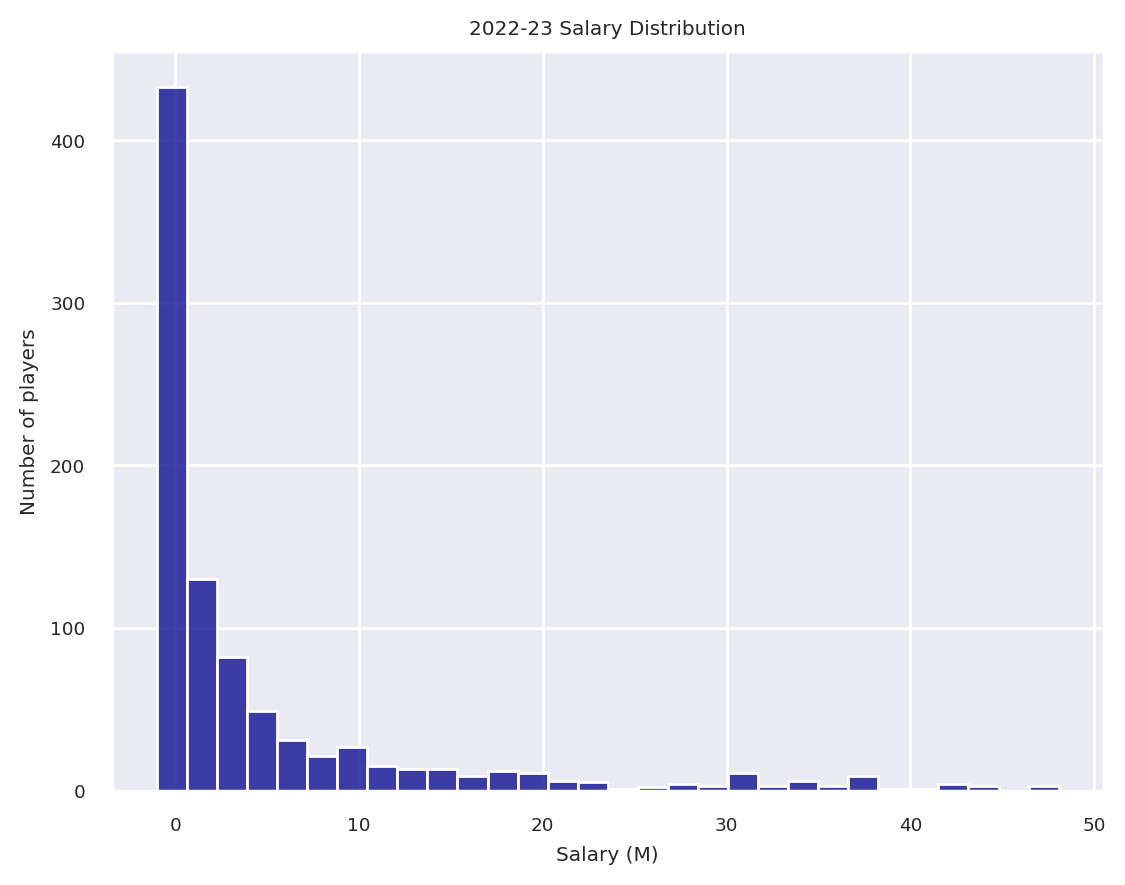

In [ ]:
# Salary distribution
sns.histplot(data=salary,x='2022-23',bins=30,color='darkblue').set(title='2022-23 Salary Distribution');
plt.xlabel('Salary (M)')
plt.ylabel('Number of players')
plt.savefig(path_data+sep+"salary_dist.jpg",dpi=300)

## Modeling

In [ ]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, modelo):

    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²

    dict_met = {'Model': [modelo],
                'RMSE': [rmse],
                'R²': [r2]}

    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])

    return metrics

In [ ]:
def train_test_data(df):

    # Take FAs out of train set
    #FA = df[(df['Player'].isin(FAs)) & (df['Season S-1']=='2022-23')].copy()
    #df = df[(df['Player'].isin(FAs)==False) | ((df['Player'].isin(FAs)) & (df['Season S-1']!='2022-23'))]
    FA = df[df['Season S-1']=='2022-23']
    df = df[df['Season S-1']!='2022-23']

    FA_X = FA.drop(columns={'Player','Tm','Salary S','Season S-1','% of Cap S'})
    FA_y = FA['% of Cap S']

    X = df.drop(columns={'Player','Tm','Salary S','Season S-1','% of Cap S'})
    y = df['% of Cap S']

    # Separating training and testing bases
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)

    X_test = pd.concat([X_test,FA_X])
    y_test = pd.concat([y_test,FA_y])
    # Shuffling
    X_test = X_test.sample(frac=1, random_state=42)
    y_test = y_test.sample(frac=1, random_state=42)

    return X_train, X_test, y_train, y_test

In [ ]:
def func_scaler(X_train, X_test):

    scaler = StandardScaler()

    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    pickle.dump(scaler,open(path_data+sep+'Models'+sep+'standard_scaler_FAs.dat','wb'))

    return scaled_X_train, scaled_X_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_data(res)
scaled_X_train, scaled_X_test = func_scaler(X_train, X_test)

In [ ]:
def func_models(scaled_X_train, scaled_X_test, y_train, y_test, models):
    metrics = pd.DataFrame()
    best_params = []

    for modelo in models:
        # Creating instance for each model
        if modelo=='SVM':
            param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5],
                         'kernel': ['linear','rbf','poly'],
                         'gamma': ['scale','auto'],
                         'degree': [2,3,4],
                         'epsilon': [0.1,0.5,1]}
            svr_model = SVR()
            grid = GridSearchCV(svr_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = SVR(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='Elastic Net':
            param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                          'l1_ratio':[0.01,0.1,0.5,0.7,0.95,1]}
            elastic_net_model = ElasticNet()
            grid = GridSearchCV(elastic_net_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            grid.best_params_
            model = ElasticNet(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='Random Forest':
            param_grid = {'n_estimators': [15,25,50,64,100,200],
                         'max_features': [2,3,5],
                         'bootstrap': [True,False],
                         'oob_score': [True]}
            rfc = RandomForestRegressor()
            grid = GridSearchCV(rfc, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = RandomForestRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='AdaBoost':
            param_grid = {'n_estimators': [5,10,25,50,100],
                         'learning_rate': [0.01,0.05,0.1,0.25,0.5]}
            ada_model = AdaBoostRegressor()
            grid = GridSearchCV(ada_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = AdaBoostRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='Gradient Boosting':
            param_grid = {'n_estimators': [10,25,50],
                         'learning_rate': [0.01,0.05,0.1,0.5],
                         'max_depth': [3,4,5]}
            gb_model = GradientBoostingRegressor()
            grid = GridSearchCV(gb_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = GradientBoostingRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='LGBM':
            param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                          'num_leaves':[5,10,25],
                          'min_data_in_leaf':[10,25,50],
                          'max_depth':[2,3,4],
                          'feature_fraction':[0.6,0.7,0.8,0.9],
                          'min_gain_to_split':[0,0.01,0.1,0.2],
                          'verbose':[-1]}
            lgbm_model = LGBMRegressor()
            grid = GridSearchCV(lgbm_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = LGBMRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo == 'Linear Regression':
            model = LinearRegression()
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
            best_params.append({})  # No hyperparameters for Linear Regression

        elif modelo == 'XGBoost':
            param_grid = {
              'n_estimators': [100, 200, 300],  # Hyperparameters for XGBoost
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 4, 5],
            }
            xgb_model = XGBRegressor()
            grid = GridSearchCV(xgb_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = grid.best_estimator_
            best_params.append(grid.best_params_)

        elif modelo == 'Decision Tree':  # New block for Decision Tree
            param_grid = {
                'max_depth': [3, 4, 5, 6],  # Hyperparameters for Decision Tree
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            dt_model = DecisionTreeRegressor()
            grid = GridSearchCV(dt_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = DecisionTreeRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo == 'CatBoost':
          param_grid = {
          'iterations': [100, 200, 300],
          'learning_rate': [0.01, 0.1, 0.2],
          'depth': [4, 6, 8],
          'l2_leaf_reg': [1, 3, 5, 7, 9]
         }
          catboost_model = CatBoostRegressor()
          grid = GridSearchCV(catboost_model, param_grid)
          grid.fit(scaled_X_train, y_train)
          model = CatBoostRegressor(**grid.best_params_)
          best_params.append(grid.best_params_)

        elif modelo == 'Extra Trees':
          param_grid = {
        'n_estimators': [15, 25, 50, 64, 100, 200],
        'max_features': [2, 3, 5],
        'bootstrap': [True, False],
        'oob_score': [True]
        }
          et_model = ExtraTreesRegressor()
          grid = GridSearchCV(et_model, param_grid)
          grid.fit(scaled_X_train, y_train)
          model = ExtraTreesRegressor(**grid.best_params_)
          best_params.append(grid.best_params_)

        model.fit(scaled_X_train, y_train)

        pickle.dump(model,open(path_data+sep+'Models'+sep+modelo+'_FAs.dat','wb'))

        y_pred = model.predict(scaled_X_test)
        metrics = func_metrics(y_test, y_pred, metrics, modelo)

    np.savetxt(path_data+sep+r'Models\params_FAs.csv', best_params, delimiter =', ', fmt ='% s')

    metrics['R²'] = metrics['R²'].apply(lambda x: '%.3f' % x)

    return metrics, best_params

In [ ]:
metrics, best_params = func_models(scaled_X_train, scaled_X_test, y_train, y_test, models)

Streaming output truncated to the last 5000 lines.
200:	learn: 0.0152412	total: 2.85s	remaining: 1.4s
201:	learn: 0.0147794	total: 2.86s	remaining: 1.39s
202:	learn: 0.0143977	total: 2.87s	remaining: 1.37s
203:	learn: 0.0141755	total: 2.88s	remaining: 1.35s
204:	learn: 0.0137516	total: 2.89s	remaining: 1.34s
205:	learn: 0.0133690	total: 2.9s	remaining: 1.32s
206:	learn: 0.0129497	total: 2.91s	remaining: 1.31s
207:	learn: 0.0125936	total: 2.92s	remaining: 1.29s
208:	learn: 0.0124128	total: 2.94s	remaining: 1.28s
209:	learn: 0.0118725	total: 2.95s	remaining: 1.26s
210:	learn: 0.0117783	total: 2.96s	remaining: 1.25s
211:	learn: 0.0114211	total: 2.97s	remaining: 1.23s
212:	learn: 0.0113020	total: 2.98s	remaining: 1.22s
213:	learn: 0.0110810	total: 2.99s	remaining: 1.2s
214:	learn: 0.0107546	total: 3s	remaining: 1.19s
215:	learn: 0.0106080	total: 3.01s	remaining: 1.17s
216:	learn: 0.0102448	total: 3.02s	remaining: 1.16s
217:	learn: 0.0100113	total: 3.04s	remaining: 1.14s
218:	learn: 0.00971

In [ ]:
metrics

,Model,RMSE,R²
0,SVM,5.59,0.168
0,Random Forest,3.87,0.601
0,Elastic Net,5.29,0.256
0,AdaBoost,5.12,0.304
0,Gradient Boosting,5.35,0.239
0,LGBM,4.96,0.346
0,Linear Regression,5.53,0.186
0,XGBoost,5.11,0.305
0,Decision Tree,5.93,0.065
0,CatBoost,4.86,0.371


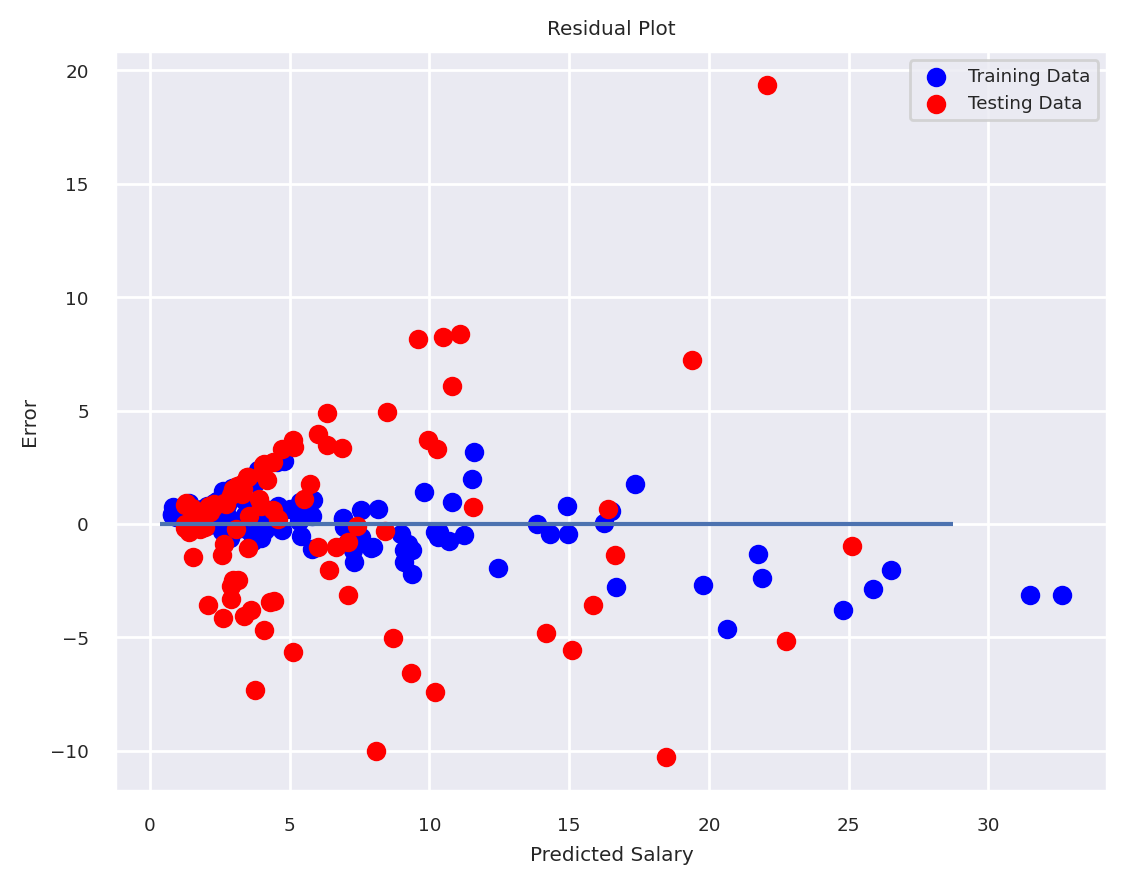

In [ ]:
rf_model = pickle.load(open(path_data+sep+'Models'+sep+'Random Forest_FAs.dat','rb'))

plt.scatter(rf_model.predict(scaled_X_train), rf_model.predict(scaled_X_train) - y_train, c="blue", label="Training Data")
plt.scatter(rf_model.predict(scaled_X_test), rf_model.predict(scaled_X_test) - y_test, c="red", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.xlabel('Predicted Salary')
plt.ylabel('Error')
plt.title('Residual Plot');

## Results

In [ ]:
def predict(df, modelos):

    final_results = pd.DataFrame()
    results = df[['Player','Season S-1','Salary S','Cap Maximum S','% of Cap S','C','PF','PG','SF','SG']].copy()

    def get_position(row):
        if row['C'] == 1:
            return 'C'
        elif row['PF'] == 1:
            return 'PF'
        elif row['PG'] == 1:
            return 'PG'
        elif row['SF'] == 1:
            return 'SF'
        elif row['SG'] == 1:
            return 'SG'
        else:
            return None

    results['Pos'] = results.apply(get_position, axis=1)
    results = results.drop(columns={'C','PF','PG','SF','SG'})

    X = df.drop(columns={'Player','Tm','Salary S','Season S-1','% of Cap S'})
    y = df['% of Cap S']

    scaler = pickle.load(open(path_data+sep+'Models'+sep+'standard_scaler_FAs.dat','rb'))

    scaled_X = scaler.transform(X)

    for modelo in modelos:

        # Opening the models already created
        model = pickle.load(open(path_data+sep+'Models'+sep+modelo+'_FAs.dat','rb'))

        y_pred = model.predict(scaled_X)

        results['Predicted % of Cap S '+modelo] = pd.Series(y_pred).values

        results['Predicted Salary S '+modelo] = results['Predicted % of Cap S '+modelo]/100*results['Cap Maximum S']

        results['Dif '+modelo] = results['Salary S']-results['Predicted Salary S '+modelo]

    final_results = results.sort_values(by='Salary S',ascending=False).reset_index(drop=True)

    return final_results

In [ ]:
final_results = predict(res, models)
final_results

,Player,Season S-1,Salary S,Cap Maximum S,% of Cap S,Pos,Predicted % of Cap S SVM,Predicted Salary S SVM,Dif SVM,Predicted % of Cap S Random Forest,Predicted Salary S Random Forest,Dif Random Forest,Predicted % of Cap S Elastic Net,Predicted Salary S Elastic Net,Dif Elastic Net,Predicted % of Cap S AdaBoost,Predicted Salary S AdaBoost,Dif AdaBoost,Predicted % of Cap S Gradient Boosting,Predicted Salary S Gradient Boosting,Dif Gradient Boosting,Predicted % of Cap S LGBM,Predicted Salary S LGBM,Dif LGBM,Predicted % of Cap S Linear Regression,Predicted Salary S Linear Regression,Dif Linear Regression,Predicted % of Cap S XGBoost,Predicted Salary S XGBoost,Dif XGBoost,Predicted % of Cap S Decision Tree,Predicted Salary S Decision Tree,Dif Decision Tree,Predicted % of Cap S CatBoost,Predicted Salary S CatBoost,Dif CatBoost,Predicted % of Cap S Extra Trees,Predicted Salary S Extra Trees,Dif Extra Trees
0,Russell Westbrook,2021-22,47.08,136.02,34.61,PG,33.77,45.93,1.15,31.50,42.84,4.24,32.60,44.34,2.74,34.61,47.08,0.00,34.22,46.55,0.53,33.21,45.17,1.91,33.99,46.23,0.85,34.56,47.01,0.07,35.18,47.86,-0.78,34.48,46.90,0.18,29.34,39.90,7.18
1,Russell Westbrook,2020-21,44.21,123.66,35.75,PG,35.25,43.59,0.62,32.64,40.36,3.85,34.49,42.65,1.57,35.18,43.51,0.71,35.25,43.58,0.63,33.35,41.24,2.97,35.26,43.60,0.61,35.73,44.18,0.03,35.18,43.51,0.71,35.78,44.25,-0.04,32.13,39.73,4.48
2,Fred VanVleet,2022-23,40.81,142.00,28.74,PG,15.69,22.28,18.53,18.47,26.22,14.58,16.26,23.09,17.72,15.17,21.53,19.27,15.56,22.09,18.71,17.50,24.85,15.95,13.14,18.66,22.14,15.85,22.51,18.29,14.86,21.10,19.70,16.63,23.62,17.19,19.45,27.62,13.18
3,Kyrie Irving,2021-22,38.92,136.02,28.61,PG,27.64,37.59,1.33,24.80,33.73,5.19,26.08,35.47,3.44,28.60,38.91,0.01,28.32,38.52,0.40,28.35,38.56,0.36,29.00,39.45,-0.53,28.60,38.90,0.01,25.85,35.17,3.75,28.56,38.85,0.07,26.78,36.43,2.49
4,Khris Middleton,2021-22,37.98,136.02,27.93,SF,27.47,37.36,0.62,22.75,30.94,7.04,26.92,36.62,1.37,27.66,37.63,0.36,28.49,38.76,-0.77,27.37,37.24,0.75,27.86,37.89,0.09,28.38,38.60,-0.61,25.85,35.17,2.82,27.04,36.77,1.21,22.08,30.03,7.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Jack White,2022-23,0.60,142.00,0.42,SF,0.03,0.04,0.56,1.26,1.78,-1.18,-0.37,-0.53,1.13,2.18,3.09,-2.49,1.20,1.70,-1.10,1.09,1.55,-0.95,-0.12,-0.17,0.77,1.08,1.53,-0.93,1.31,1.86,-1.26,0.81,1.16,-0.56,1.66,2.36,-1.76
242,Jeff Dowtin,2021-22,0.51,136.02,0.37,PG,0.59,0.80,-0.29,1.30,1.77,-1.26,0.03,0.04,0.47,2.18,2.96,-2.45,0.50,0.68,-0.17,0.87,1.18,-0.67,-1.51,-2.06,2.57,0.47,0.64,-0.13,1.31,1.78,-1.27,0.66,0.90,-0.39,1.23,1.67,-1.16
243,Luka Garza,2021-22,0.51,136.02,0.37,C,-0.13,-0.17,0.68,0.78,1.06,-0.55,0.21,0.28,0.23,2.18,2.96,-2.45,1.03,1.40,-0.89,1.15,1.56,-1.05,0.06,0.08,0.43,0.44,0.59,-0.08,1.31,1.78,-1.27,0.44,0.60,-0.09,0.76,1.03,-0.52
244,Nathan Knight,2020-21,0.46,123.66,0.37,PF,1.73,2.14,-1.67,0.80,0.99,-0.52,0.89,1.10,-0.63,2.18,2.69,-2.23,0.67,0.83,-0.36,0.97,1.20,-0.74,2.55,3.15,-2.69,0.37,0.46,0.01,1.31,1.62,-1.16,0.52,0.64,-0.18,1.04,1.28,-0.82


In [ ]:
final_results.sort_values(by='Dif Extra Trees').reset_index(drop=True)

,Player,Season S-1,Salary S,Cap Maximum S,% of Cap S,Pos,Predicted % of Cap S SVM,Predicted Salary S SVM,Dif SVM,Predicted % of Cap S Random Forest,Predicted Salary S Random Forest,Dif Random Forest,Predicted % of Cap S Elastic Net,Predicted Salary S Elastic Net,Dif Elastic Net,Predicted % of Cap S AdaBoost,Predicted Salary S AdaBoost,Dif AdaBoost,Predicted % of Cap S Gradient Boosting,Predicted Salary S Gradient Boosting,Dif Gradient Boosting,Predicted % of Cap S LGBM,Predicted Salary S LGBM,Dif LGBM,Predicted % of Cap S Linear Regression,Predicted Salary S Linear Regression,Dif Linear Regression,Predicted % of Cap S XGBoost,Predicted Salary S XGBoost,Dif XGBoost,Predicted % of Cap S Decision Tree,Predicted Salary S Decision Tree,Dif Decision Tree,Predicted % of Cap S CatBoost,Predicted Salary S CatBoost,Dif CatBoost,Predicted % of Cap S Extra Trees,Predicted Salary S Extra Trees,Dif Extra Trees
0,Russell Westbrook,2022-23,3.84,142.00,2.70,PG,33.48,47.54,-43.70,22.06,31.33,-27.49,32.48,46.12,-42.28,28.64,40.67,-36.84,33.38,47.40,-43.57,27.69,39.32,-35.48,31.69,45.00,-41.17,29.56,41.97,-38.14,35.18,49.96,-46.12,29.08,41.29,-37.45,22.55,32.02,-28.18
1,Kevin Love,2022-23,3.84,142.00,2.70,PF,21.60,30.67,-26.83,11.10,15.76,-11.92,19.91,28.27,-24.44,23.51,33.38,-29.55,23.11,32.81,-28.98,22.06,31.33,-27.50,19.56,27.78,-23.94,21.69,30.80,-26.96,25.85,36.71,-32.88,16.03,22.77,-18.93,12.43,17.65,-13.82
2,Eric Gordon,2022-23,3.20,142.00,2.25,SG,13.62,19.34,-16.14,10.48,14.89,-11.69,13.42,19.05,-15.86,14.90,21.16,-17.97,14.80,21.01,-17.81,14.09,20.01,-16.81,11.48,16.31,-13.11,13.33,18.92,-15.73,14.86,21.10,-17.91,13.53,19.21,-16.01,9.83,13.95,-10.76
3,Malik Beasley,2022-23,2.02,142.00,1.42,SG,10.88,15.45,-13.43,9.58,13.61,-11.59,10.88,15.45,-13.43,8.99,12.76,-10.74,10.51,14.93,-12.91,9.36,13.29,-11.27,8.57,12.17,-10.15,10.11,14.36,-12.34,9.40,13.35,-11.33,11.49,16.31,-14.29,8.28,11.75,-9.73
4,Coby White,2020-21,5.84,123.66,4.72,PG,6.34,7.83,-2.00,10.80,13.35,-7.51,6.62,8.19,-2.35,6.70,8.28,-2.44,5.78,7.15,-1.31,6.56,8.12,-2.28,7.57,9.36,-3.52,5.35,6.61,-0.78,3.57,4.42,1.42,6.82,8.43,-2.60,11.22,13.88,-8.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Brook Lopez,2022-23,25.00,142.00,17.61,C,10.03,14.24,10.76,10.19,14.47,10.53,10.49,14.89,10.11,9.36,13.29,11.71,11.02,15.65,9.35,11.09,15.75,9.25,12.16,17.26,7.74,11.97,16.99,8.01,9.40,13.35,11.65,12.26,17.41,7.59,11.52,16.36,8.64
242,Dillon Brooks,2022-23,22.63,142.00,15.93,SF,7.57,10.75,11.88,9.34,13.27,9.36,8.30,11.78,10.84,9.12,12.94,9.68,9.12,12.95,9.68,9.05,12.84,9.78,7.85,11.14,11.48,9.72,13.80,8.82,9.40,13.35,9.28,8.17,11.60,11.03,9.77,13.87,8.75
243,Rui Hachimura,2022-23,15.74,142.00,11.09,PF,4.40,6.25,9.49,3.76,5.33,10.41,4.27,6.06,9.68,3.17,4.50,11.24,3.84,5.45,10.29,3.67,5.21,10.53,4.33,6.15,9.59,3.47,4.93,10.81,3.57,5.07,10.67,2.74,3.89,11.85,4.37,6.21,9.53
244,Fred VanVleet,2022-23,40.81,142.00,28.74,PG,15.69,22.28,18.53,18.47,26.22,14.58,16.26,23.09,17.72,15.17,21.53,19.27,15.56,22.09,18.71,17.50,24.85,15.95,13.14,18.66,22.14,15.85,22.51,18.29,14.86,21.10,19.70,16.63,23.62,17.19,19.45,27.62,13.18


## Free Agents - 2023-24 Season

In [ ]:
free_agents = final_results[['Player','Salary S','% of Cap S','Predicted Salary S Extra Trees',
                            'Predicted % of Cap S Extra Trees','Dif Extra Trees']][final_results['Season S-1']=='2022-23'].sort_values('Dif Extra Trees')
free_agents

,Player,Salary S,% of Cap S,Predicted Salary S Extra Trees,Predicted % of Cap S Extra Trees,Dif Extra Trees
130,Russell Westbrook,3.84,2.70,32.02,22.55,-28.18
129,Kevin Love,3.84,2.70,17.65,12.43,-13.82
135,Eric Gordon,3.20,2.25,13.95,9.83,-10.76
182,Malik Beasley,2.02,1.42,11.75,8.28,-9.73
30,D'Angelo Russell,17.31,12.19,24.10,16.97,-6.79
...,...,...,...,...,...,...
17,Brook Lopez,25.00,17.61,16.36,11.52,8.64
19,Dillon Brooks,22.63,15.93,13.87,9.77,8.75
31,Rui Hachimura,15.74,11.09,6.21,4.37,9.53
2,Fred VanVleet,40.81,28.74,27.62,19.45,13.18


In [ ]:
a = int(len(free_agents) / 2)+5
b = int((len(free_agents) / 2) + 10)
free_agents.iloc[a:b]

,Player,Salary S,% of Cap S,Predicted Salary S Extra Trees,Predicted % of Cap S Extra Trees,Dif Extra Trees
204,AJ Green,1.90,1.34,2.36,1.66,-0.46
177,Alex Len,2.02,1.42,2.40,1.69,-0.38
110,Nickeil Alexander-Walker,4.69,3.30,4.93,3.47,-0.24
184,Frank Ntilikina,2.02,1.42,2.20,1.55,-0.18
213,Orlando Robinson,1.80,1.27,1.90,1.33,-0.09


In [ ]:
metr = pd.DataFrame()
metr = func_metrics(free_agents['% of Cap S'], free_agents['Predicted % of Cap S Extra Trees'], metr, 'Extra Trees')
metr

,Model,RMSE,R²
0,Extra Trees,4.04,0.55


## Position Analysis - 2023-24 Season

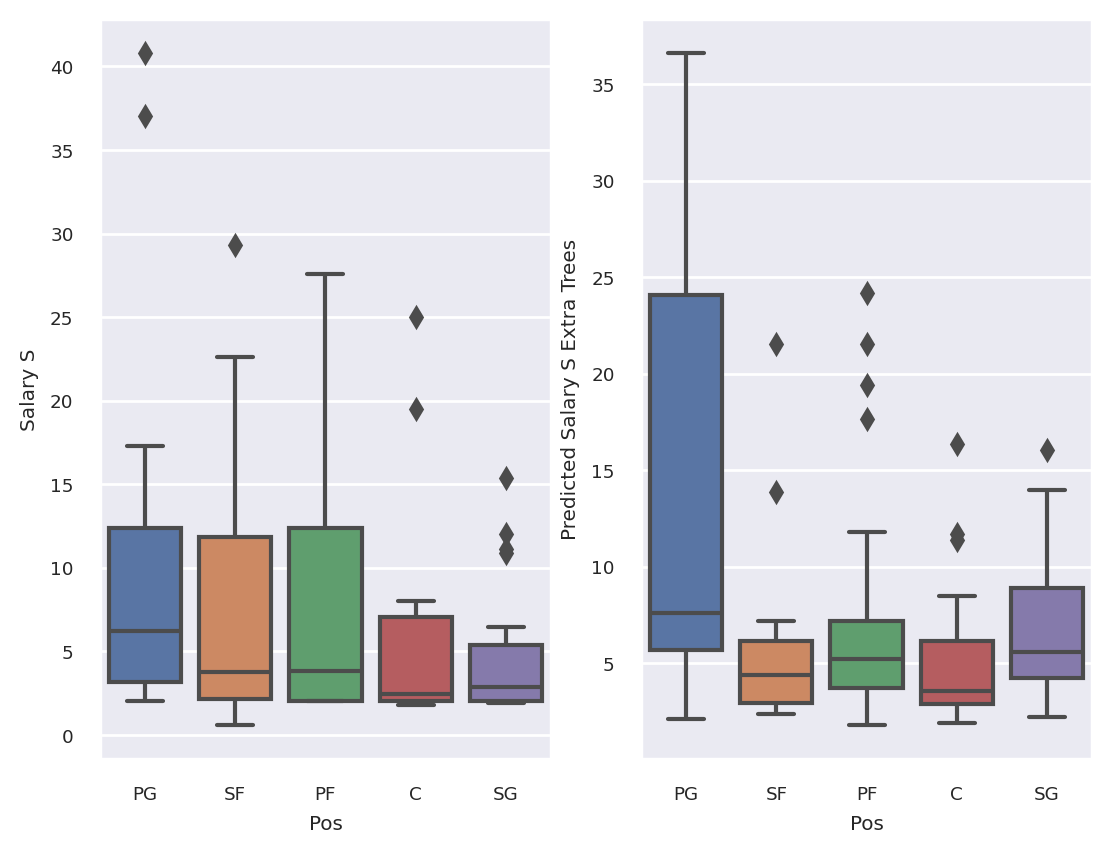

In [ ]:
fig, ax = plt.subplots(1,2)

positions = final_results[final_results['Season S-1']=='2022-23']

sns.boxplot(x='Pos', y='Salary S', data=positions, ax=ax[0])
sns.boxplot(x='Pos', y='Predicted Salary S Extra Trees', data=positions, ax=ax[1]);

In [ ]:
positions.groupby('Pos').agg({'Salary S':'mean',
                            'Predicted Salary S Extra Trees':'mean',
                             'Player':'count'}).sort_values(by='Salary S', ascending=False).reset_index()

,Pos,Salary S,Predicted Salary S Extra Trees,Player
0,PG,11.71,13.92,13
1,PF,8.82,7.95,21
2,SF,8.72,6.43,12
3,C,5.61,5.41,18
4,SG,4.87,6.73,20


## Variable Analysis - SHAP

In [ ]:
explainer = shap.KernelExplainer(rf_model.predict, scaled_X_test)
shap_values = explainer.shap_values(scaled_X_test)

shap.initjs()

  0%|          | 0/104 [00:00<?, ?it/s]

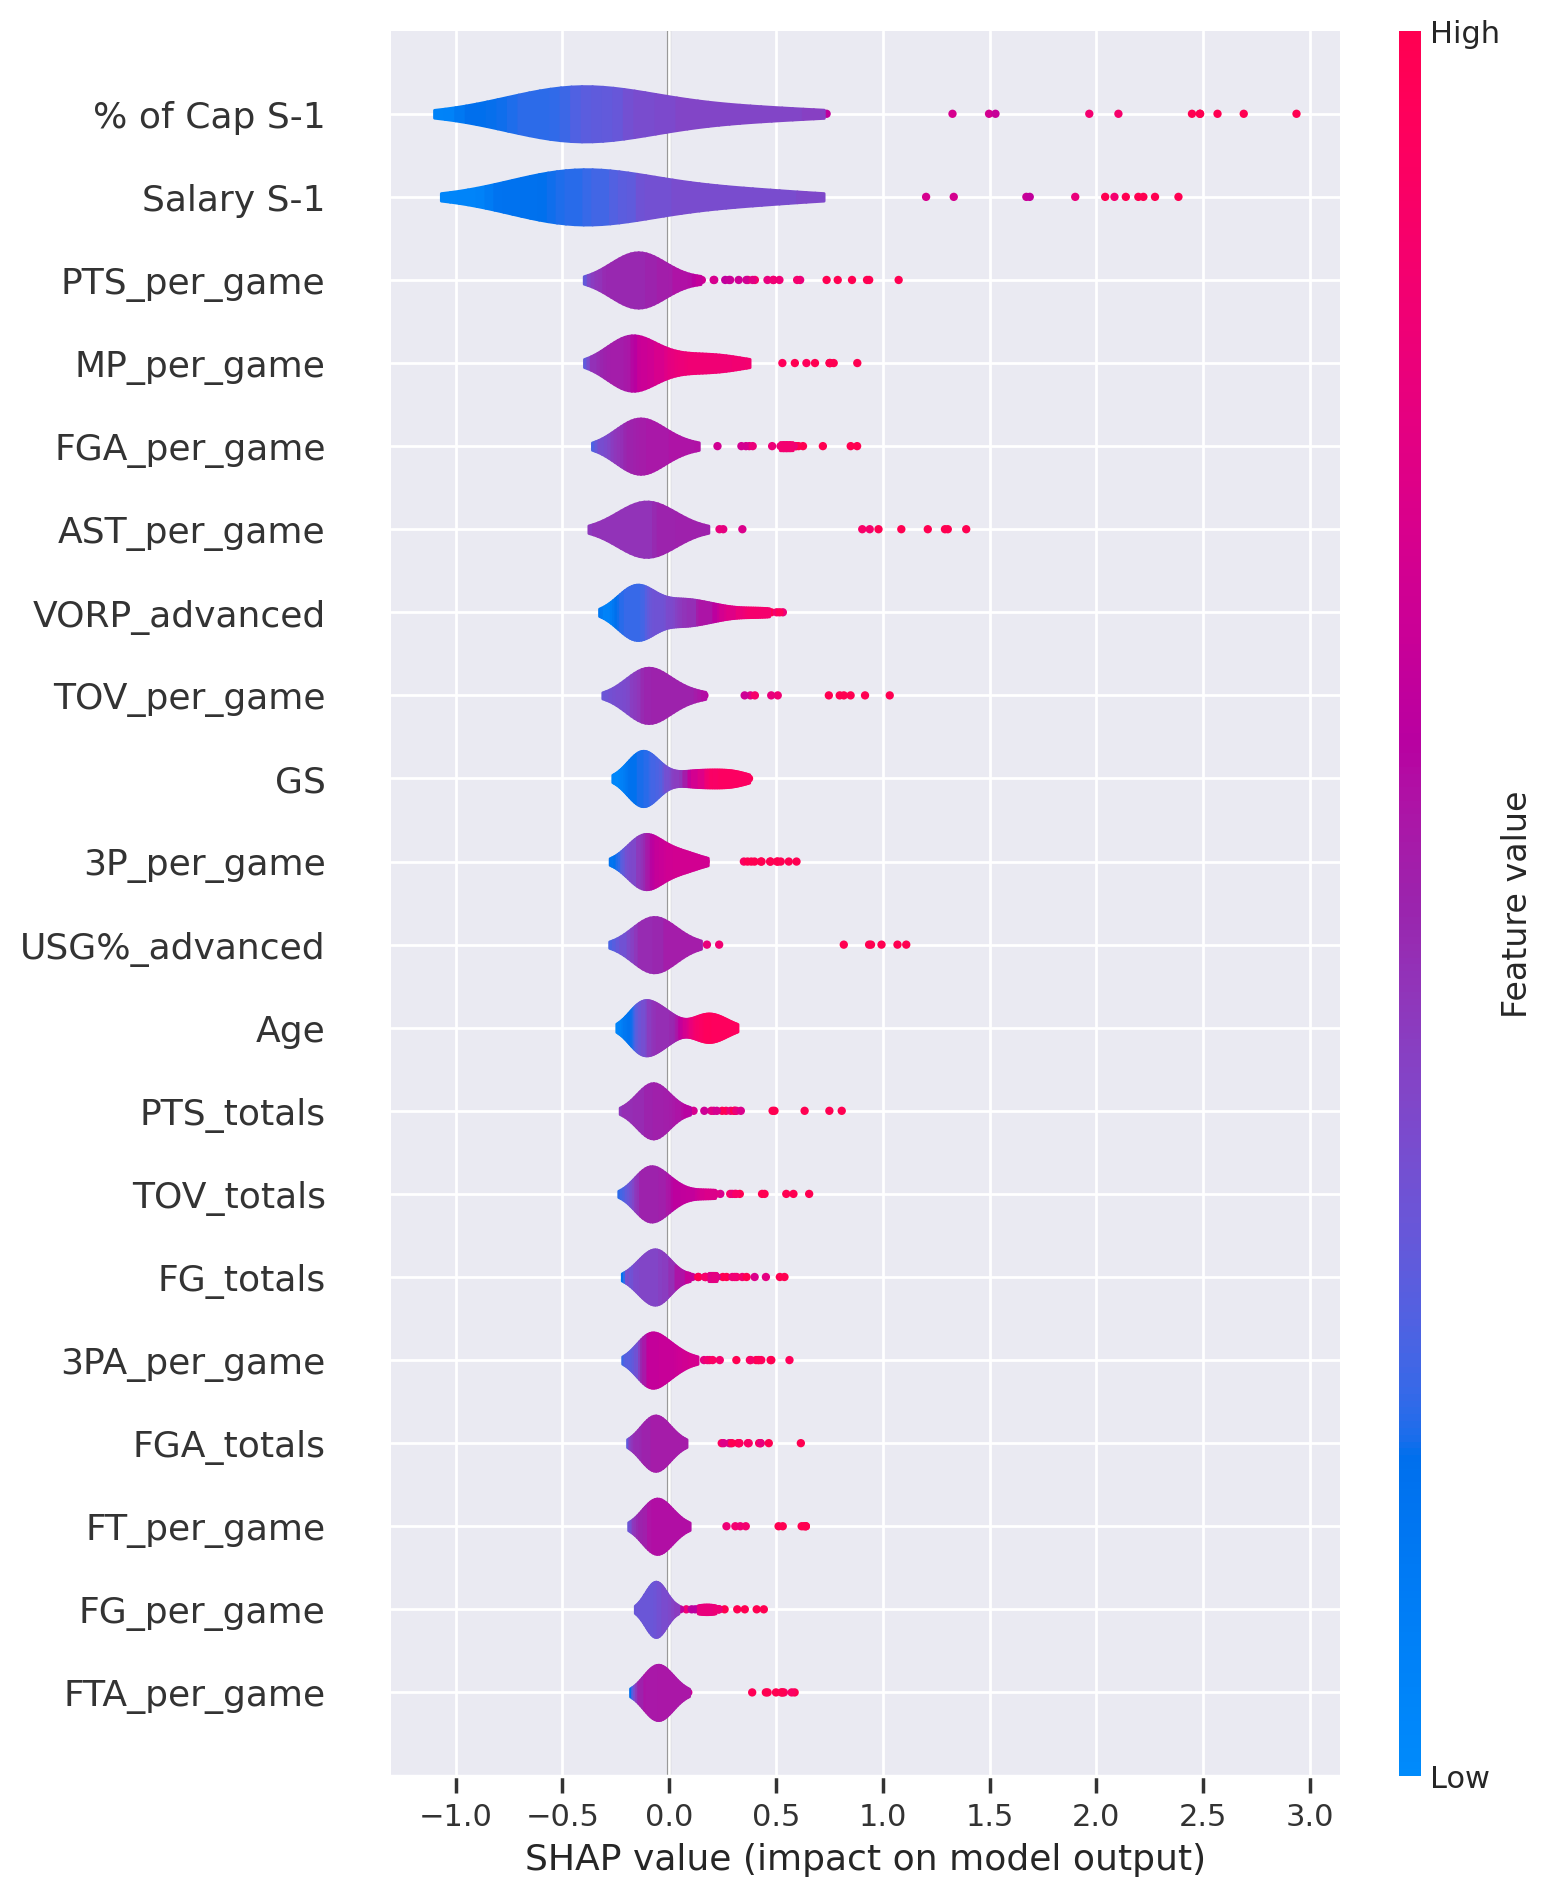

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='violin') # Top 20 variáveis

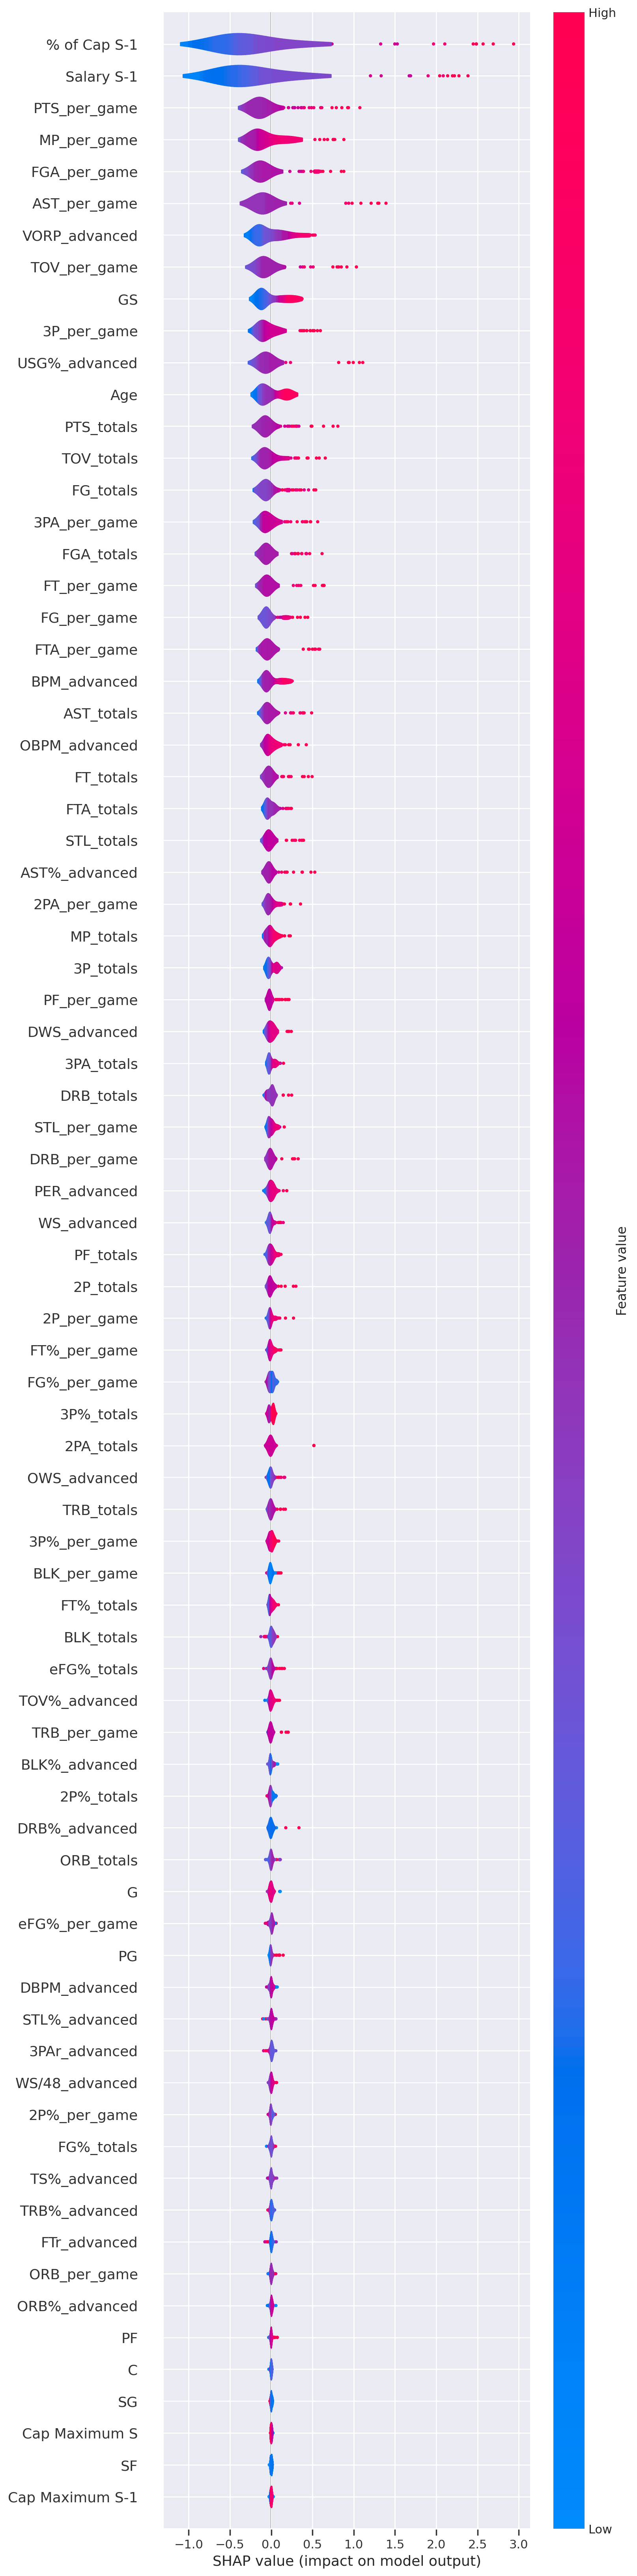

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='violin', max_display=len(X_test.columns)) # Todas as variáveis